# Transformers for Language Modeling 

### Introduction

In this notebook, I will be implementing a Transformer, `SastaGPT`, from scratch. This will be taken from the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017). I will then train this Transformer on a language modeling task on a dataset. For the dataset, I have chosen selected poems of Edgar Allan Poe.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install tiktoken

import torch
import torch.nn as nn
import torch.nn.functional as F

import tiktoken

## Creating a Dataset 

In this section, you will be creating a dataset for training your Transformer. You can use any dataset you want, as long as it is a text dataset.

Some fun options include:

- A collection of movie scripts from your favorite director. Look through [IMSDB](https://www.imsdb.com/) for some options.

- A novel from your favorite author. Look through [Project Gutenberg](https://www.gutenberg.org/) for some options.

- A collection of poems from your favorite poet. Look through [Poetry Foundation](https://www.poetryfoundation.org/) for some options.

- Anything else from [Kaggle](https://www.kaggle.com/datasets) or [HuggingFace](https://huggingface.co/datasets).

This section involves doing the following:

 **Preprocessing your dataset**. This involves tokenizing your dataset, and creating a vocabulary. I will use **subword-level tokenization** (you can read about different tokenization strategies [here](https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt)). This can be very easily handled with the `tiktoken` library (read up [here](https://github.com/openai/tiktoken)), which is also what the GPT family uses

In [4]:
BATCH_SIZE = 32
BLOCK_SIZE = 8

# Create tiktoken object
encoder = tiktoken.get_encoding("gpt2")

#   Read in your dataset

with open('data.txt', 'r', encoding='utf-8') as f:
    dataset = f.read()

#   Create the encoded ids using the encoder
encoded_dataset = encoder.encode(dataset)
encoded_dataset_tensor = torch.tensor(encoded_dataset, dtype=torch.int64)

#   Complete the get_batch function
def get_batch():
    '''
    Returns a batch (x, y) from the dataset
    '''
    #   Get random integers for indexing into the dataset to create a batch
    indices = np.random.randint(0, len(encoded_dataset_tensor) - BLOCK_SIZE - 1, BATCH_SIZE)
    
    #   Get the x and y (input and target) batches after encoding and indexing
    #   Make sure these are int64 (long) tensors
    x = torch.zeros(BATCH_SIZE, BLOCK_SIZE, dtype=torch.int64)
    y = torch.zeros(BATCH_SIZE, BLOCK_SIZE, dtype=torch.int64)
    
    for i in range(BATCH_SIZE):
        start_index = indices[i]
        end_index = start_index + BLOCK_SIZE
        
        x[i] = encoded_dataset_tensor[start_index:end_index]
        y[i] = encoded_dataset_tensor[start_index + 1:end_index + 1]
        
    return x, y

xb, yb = get_batch()
xb.shape, yb.shape

(torch.Size([32, 8]), torch.Size([32, 8]))

## Creating the Transformer

### Defining our Hyperparameters 

We will define our hyperparameters here. You can play around with these later to see how they affect your model.

Since there are lots of hyperparameters to keep track of, it is easier for us to wrap all of them inside a `dataclass`. This can be passed around very easily to different functions, and makes it easier to keep track of all relevant values.

To quickly describe some of the hyperparameters:

1. `block_size`: This is the length of the sequence that we will be feeding into our model. This has also been called the *context length* and *window size* in other places.

2. `emb_dim`: This is the dimensionality of the embeddings we will have inside the model. This has implications on the outputs of tensors throughout the entire model.

3. `head_size`: When dealing with Multi-Head Attention, we will be *splitting* our embeddings into multiple heads. This is the size of each of those heads. For example, if we had an embedding of size 512, and we wanted 8 heads, then each head would have a size of 64. Down the line, we'd be concatenating these heads together, so the final output would be of size 512 again, as you should recall from the lectures.

4. `num_heads`: This is the number of attention heads we will have in our Multi-Head Attention layer.

5. `num_layers`: This is the number of layers we will have in our Transformer (this includes the MHSA, the Feedforward module, and the Layer Normalizations).

6. `vocab_size`: This is the size of our vocabulary. This is the number of unique tokens we have in our vocabulary. If you were to use character-level tokenization, this would be the number of unique characters in your dataset. Since you should be using subword-level tokenization, this will be the number of unique subwords in your dataset.

In [5]:
from dataclasses import dataclass

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256
    head_size: int = 32
    num_heads: int = 8
    num_layers: int = 2
    vocab_size: int = encoder.n_vocab # vocab size of the tokenizer

# We like to have emb_dim == head_size * num_heads
config = Config()
assert config.emb_dim == config.head_size * config.num_heads, "Embedding dimension must be divisible by number of heads"

### Multi-Head Self-Attention 

This component is the core of the Transformer. This is where the model learns to attend to different parts of the input sequence, and is the reason why Transformers are so powerful.

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

$$\text{head}_k = \text{Attention}(QW^Q_k, KW^K_k, VW^V_k)$$

$$\text{MHSA}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

For simplicity, assume we have a single Head:

1. The input has three parts extracted from it: the query $Q$, the key $K$, and the value $V$ (via projections or `Linear` layers). 

2. The query and key are multiplied together to get a score. This score is then scaled by the square root of the embedding dimension, $\sqrt{d_k}$, then passed through a softmax to get the attention weights (*after* a masking operation is applied).

3. The attention weights are then multiplied with the value to get the final output.

When we extend this to *multiple heads*, we simply repeat this process for each head in parallel, and then concatenate the outputs of each head together.

I have created a class for this `MHSA` module (Multi-Head Self-Attention), adding a comment next to each line in the `forward` method for the shape of the tensor at that point to help with debugging later on. 

In [11]:
class MHSA(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emb_dim = cfg.emb_dim
        self.head_size = cfg.head_size
        self.block_size = cfg.block_size
        self.num_heads = cfg.num_heads

        #   Define the single projection layer for QKV
        self.query = nn.Linear(self.emb_dim, self.head_size * self.num_heads)
        self.key = nn.Linear(self.emb_dim, self.head_size * self.num_heads)
        self.value = nn.Linear(self.emb_dim, self.head_size * self.num_heads)
        
        #   Define the output projection layer
        self.out = nn.Linear(self.head_size * self.num_heads, self.emb_dim)

        # Create a buffer for the mask (buffers are tensors that are not updated during backpropagation)
        self.register_buffer("mask", torch.tril(torch.ones(self.block_size, self.block_size)))

    def forward(self, x):

        B, T, C = x.shape # batch size, block size, emb dim
        H = self.num_heads

        #   Carry out the projections to get the query, key and value - you may want to reshape them to (B, H, T, head_size) to make things easier
        Q = self.query(x).view(B, T, H, C // H).transpose(1, 2)  
        K = self.key(x).view(B, T, H, C // H).transpose(1, 2)    
        V = self.value(x).view(B, T, H, C // H).transpose(1, 2)  

        #   Compute the attention scores, perform masking, and apply the softmax
        attn_scores = Q @ K.transpose(-2, -1)  # (B, H, T, T)
        attn_scores = attn_scores / torch.sqrt(torch.tensor(self.head_size, dtype=torch.float32))
        attn_scores = attn_scores.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attn_probs = F.softmax(attn_scores, dim=-1)
        out = attn_probs @ V  # (B, H, T, head_size)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        out = self.out(out)
        #   Compute the weighted sum of the value vectors - you can perform the concatenation via a simple reshaping before applying the final projection

        return out

# !DO NOT REMOVE THESE LINES!
x = torch.randn(32, config.block_size, config.emb_dim)
print(x.shape)
csa = MHSA(config)
out = csa(x)
print(out.shape)

torch.Size([32, 8, 256])
torch.Size([32, 8, 256])


### Feedforward Network 

The Feedforward Network module usually consists of two linear layers, with a ReLU activation in between. The first linear layer projects the input's Embeddings to a higher dimensionality (by a factor of 4 specifically), and the second linear layer projects it back down to the original dimensionality. This is a very simple module, but is very effective in learning complex functions.

I will create a class for this `Feedforward` module, with the following tweaks:

1. Use the [GELU Activation Function](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) instead of ReLU between the layers. It is functionally very similar, but has gained a lot of popularity recently.

2. Instead of using two `Linear` layers, and an upsampling factor of `4`, use **three** `Linear` layers: the first one upsamples by a factor of `2`, the second one does not change the dimensionality, and the third one downsamples by a factor of `2`. This creates a slightly deeper network, and can be shown to have the same number of parameters as the network in the original Transformer.

3. Add a [Dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) after the last `Linear` layer, with $p=0.1$. This helps mitigate overfitting.

In [12]:
class Feedforward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim

        #   Define the feedforward network
        self.linear1 = nn.Linear(self.emb_dim, self.emb_dim * 2)
        self.linear2 = nn.Linear(self.emb_dim * 2, self.emb_dim * 2)
        self.linear3 = nn.Linear(self.emb_dim * 2, self.emb_dim)
        self.dropout = nn.Dropout(p=0.1)


    def forward(self, x):
        #   Apply the feedforward network
        x = F.gelu(self.linear1(x))
        x = F.gelu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)

        return x

### Blocks with Skip Connections 

The Encoder consists of multiple *Blocks*, that each contain a Multi-Head Self-Attention module, a Feedforward module, and a Layer Normalization module. We use Skip Connections to help with the flow of gradients during the training process.

I have created a class for this `Block` module, with the following tweaks:

- Instead of creating your own Layer Normalization module, I use [the one provided by PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html), `nn.LayerNorm`.

- I perform the Layer Normalizations **before** the Skip Connections, instead of after. The original paper used the "post-LN" approach, but [recent research](https://arxiv.org/abs/2002.04745) has shown that the "pre-LN" approach is better.

In [14]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()

        #   Define the MHSA, Feedforward, and two LayerNorm modules
        self.mhsa = MHSA(config)
        self.feedforward = Feedforward(config)
        self.norm1 = nn.LayerNorm(config.emb_dim)
        self.norm2 = nn.LayerNorm(config.emb_dim)

    def forward(self, x):

        #   Apply the modules with residual connections (use the Pre-LN design)
        x_norm = self.norm1(x)
        x = x + self.mhsa(x_norm)
        x_norm = self.norm2(x)
        x = x + self.feedforward(x_norm)
        return x

# !DO NOT REMOVE THESE LINES!
x = torch.randn(8, config.block_size, config.emb_dim)
print(x.shape)
block = Block(config)
out = block(x)
print(out.shape)

torch.Size([8, 8, 256])
torch.Size([8, 8, 256])


### Putting it all together 

Now that we have all the components, we can put them together to create the Transformer. The Transformer consists of

1. Creating Embeddings for the input sequence. This implies turning the input sequence into a sequence of indices, and then passing it through an `nn.Embedding` layer. Alongside this, we will be using another Embedding table for the positional encodings. For simplicity, we can keep the embedding dimensionality for both of these the same.

2. Passing the embeddings through a series of Blocks.

3. Passing the output of the Encoder through a Layer Normalization layer, and then a Linear layer to get the final logits.

FInally, I have created a class for this `SastaGPT` module. This will be the final model that I will be training.

In [15]:
class SastaGPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.block_size = config.block_size
        self.num_layers = config.num_layers
        self.vocab_size = config.vocab_size 

        #   Define the word and position embeddings
        #  They will both have the same embedding dimension, only difference is the number of embeddings (vocab_size vs. block_size)
        self.token_embedding = nn.Embedding(self.vocab_size, self.emb_dim)
        self.position_embedding = nn.Embedding(self.block_size, self.emb_dim)
        
        #   Define the sequence of Blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(self.num_layers)])

        #   Define the final LayerNorm
        self.ln_f = nn.LayerNorm(self.emb_dim)
        
        #   Define the final linear layer (to get logits)
        self.head = nn.Linear(self.emb_dim, self.vocab_size, bias=False)

        # Initialize the weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idxs):
        # idxs: (B, T)
        batch_size, seq_len = idxs.shape

        assert seq_len <= self.block_size, f"Sequence length exceeds block size of {self.block_size}"

        #   Get the word embeddings (B, T, C) and position embeddings (T, C)
        # for the position embeddings, you can use torch.arange(seq_len) to mimic the indices
        #  position embeddings are encodings of the position indices (NOT the actual tokens)
        token_embeddings = self.token_embedding(idxs)  # (B, T, C)
        position_ids = torch.arange(seq_len, device=idxs.device).unsqueeze(0).expand_as(idxs)
        position_embeddings = self.position_embedding(position_ids)  # (B, T, C)

        #   Add the word and position embeddings (broadcasting will take care of the shapes)
        x = token_embeddings + position_embeddings

        #   Pass the embeddings through the blocks (B, T, C)
        for block in self.blocks:
            x = block(x)

        #   Apply the final LayerNorm
        x = self.ln_f(x)

        #   Apply the final linear layer to get the logits (B, T, V)
        logits = self.head(x)
        
        return logits
    
    @torch.no_grad()
    def generate(self, idxs, max_new_tokens=20):
        '''
        Takes in a sequence of indices (the tokenized sentence) and generates new tokens
        Note that the input indices should not be longer than the block size
        Returns the input sequence with the generated tokens appended (these should be decoded using the Tokenizer)

        Params
        ------
        idxs: torch.Tensor
            (B, T) tensor of token indices
        max_new_tokens: int
            Maximum number of new tokens to generate
        '''

        # idxs: (B, T)
        for _ in range(max_new_tokens):
            idxs_trimmed = idxs[:, -self.block_size:] # trim to block size

            logits = self(idxs_trimmed) # (B, T, V)

            logits = logits[:, -1, :] # (B, V)
            
            probs = F.softmax(logits, dim=-1) # (B, V)

            next_idx = torch.multinomial(probs, num_samples=1) # (B, 1)

            idxs = torch.cat((idxs, next_idx), dim=1) # (B, T+1)
            
        return idxs

cfg = Config()
model = SastaGPT(cfg)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()) / 1e6 :.3f}M")

Number of parameters: 27.314M


In [16]:

# Check out the forward pass
xb, yb = get_batch()
print(xb.shape)

logits = model(xb)
print(logits.shape) # (B, T, V)

torch.Size([32, 8])
torch.Size([32, 8, 50257])


Now I train this model on the dataset of poems that I have collected!

Note that since the model is quite large, it will take a while to train. This would be a good opportunity to use [Google Colab](https://colab.research.google.com/) or [Kaggle Notebooks](https://www.kaggle.com/notebooks) for free GPU compute. This requires very few changes to your original training code, only having to cast your model and data to the GPU.

```python
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the batch
xb, yb = get_batch()

# Cast to the device
xb = xb.to(device)
yb = yb.to(device)

# Cast the model to the device
model = model.to(device)

# Forward pass
preds = model(xb)

...

```

The only rule is that both your model and your tensors should be on the same device (CPU or GPU).

In [17]:
#   Train the model

import torch.optim as optim


device = torch.device("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 5000

model = model.to(device)

for epoch in range(num_epochs):

    xb, yb = get_batch()
    xb = xb.to(device)
    yb = yb.to(device)
    optimizer.zero_grad()
    preds = model(xb)
    loss = criterion(preds.view(-1, preds.size(-1)), yb.view(-1))
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()}")

Epoch 0 | Loss: 10.88924503326416
Epoch 500 | Loss: 3.3086578845977783
Epoch 1000 | Loss: 1.3978257179260254
Epoch 1500 | Loss: 0.7870641350746155
Epoch 2000 | Loss: 0.6080127358436584
Epoch 2500 | Loss: 0.4502527117729187
Epoch 3000 | Loss: 0.5747054219245911
Epoch 3500 | Loss: 0.34539419412612915
Epoch 4000 | Loss: 0.4782426953315735
Epoch 4500 | Loss: 0.4671880304813385


With your trained model, lets generate some text using the generate() method.

Note that the quality of your generations depends on:

- How large the training dataset was. If you used a small dataset, your model will not have enough samples to learn the syntax, semantics, the grammar and other intricacies of language, much less the specifics of the dataset.

- How long you trained for. Provided your dataset was large enough, you could try training for longer epochs until the loss values stabilize.

- How large your model was. If you used a small model, it will not have enough parameters to learn the complexities of language. You can try increasing the number of layers, the embedding dimensionality, the number of heads, etc.

In [18]:
sentence = " "
idxs = torch.tensor(encoder.encode(sentence)).unsqueeze(0)

model.eval()
generated = model.generate(idxs, max_new_tokens=100)
res = encoder.decode(generated[0].numpy())
print(res)

   
On a black throne reigns upright,
I have reached these lands but newly   
From an ultimate dim Thule—
From a wild weird clime that lieth, sublime,
         Out of SPACE—Out of TIME.

Bottomless vales and boundless floods,   
And neither the angels in Heaven above
   Nor the demons down under the sea
Can ever dissever my soul from


## Effects of Hyperparameters on the Number of Parameters 

Let us now explore the effects of the hyperparameters on the number of parameters in our model. 

With so much room for tweaking (with the embedding dimensionality, the size of the vocab, the number of heads, the number of layers, etc.), it is important to visualize how fast the total number of parameters can grow if we start toying with them.

In [19]:
def get_params(model):
    '''
    Returns the number of parameters in the model (in millions)
    '''
    return sum(p.numel() for p in model.parameters()) / 1e6

@dataclass
class Config:
    block_size: int = BLOCK_SIZE
    emb_dim: int = 256
    head_size: int = 32
    num_heads: int = 8
    num_layers: int = 2
    vocab_size: int = 100 # smaller vocab size for quick prototyping

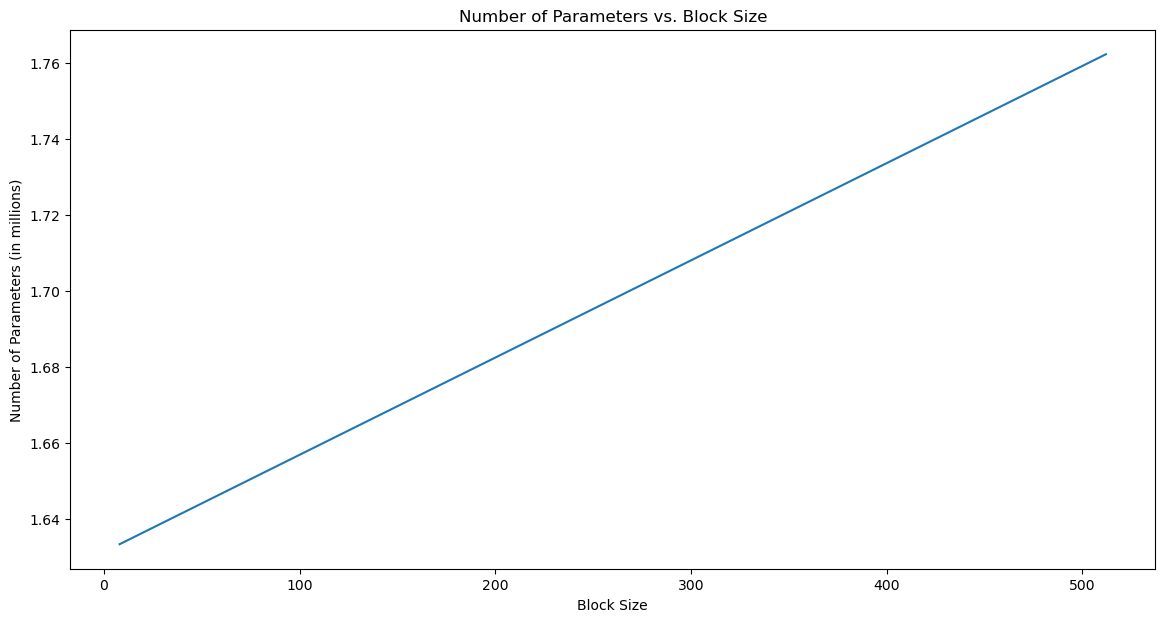

In [20]:
#  lets plot the number of parameters vs. block size (in multiples of 8, capped at 512)

block_sizes = range(8, 513, 8)  # Block sizes in multiples of 8, capped at 512
params_by_block_size = []

for bs in block_sizes:
    config = Config(block_size=bs)
    model = SastaGPT(config)
    params_by_block_size.append(get_params(model))

plt.figure(figsize=(14, 7))
plt.plot(block_sizes, params_by_block_size)
plt.title('Number of Parameters vs. Block Size')
plt.xlabel('Block Size')
plt.ylabel('Number of Parameters (in millions)')
plt.show()

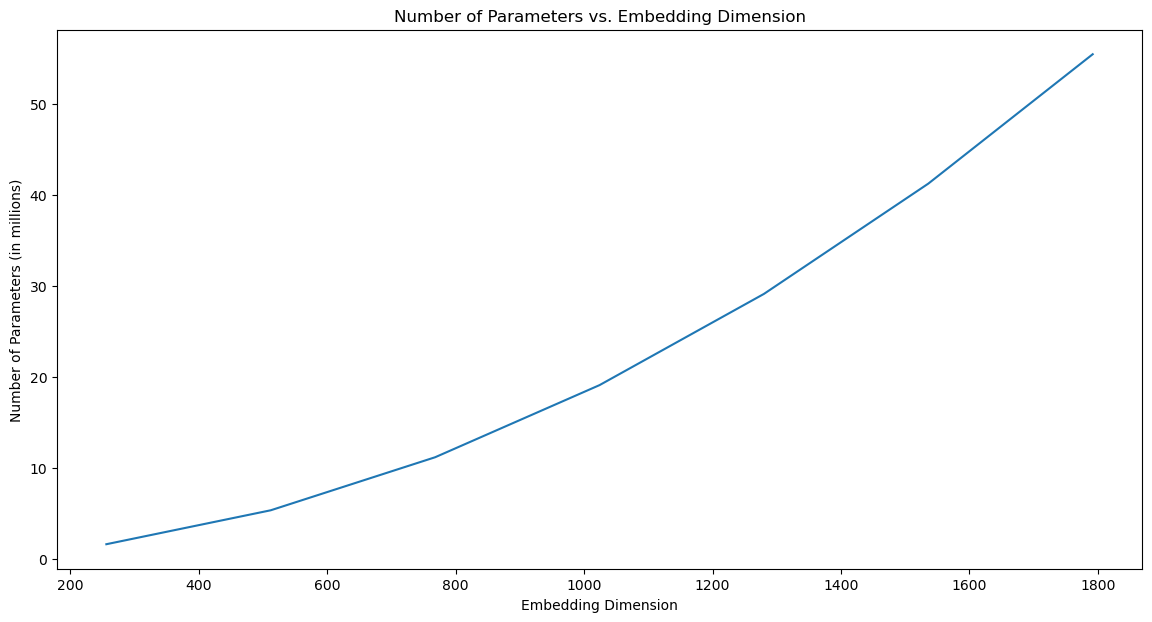

In [21]:
#   now lets plot the number of parameters vs. embedding dimension (in multiples of 256, capped at 1792)

e_dims = range(256, 1793, 256)  
params_by_emb_dim = []

for ed in e_dims:
    config = Config(emb_dim=ed)
    model = SastaGPT(config)
    params_by_emb_dim.append(get_params(model))
    
plt.figure(figsize=(14, 7))
plt.plot(e_dims, params_by_emb_dim)
plt.title('Number of Parameters vs. Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Number of Parameters (in millions)')
plt.show()

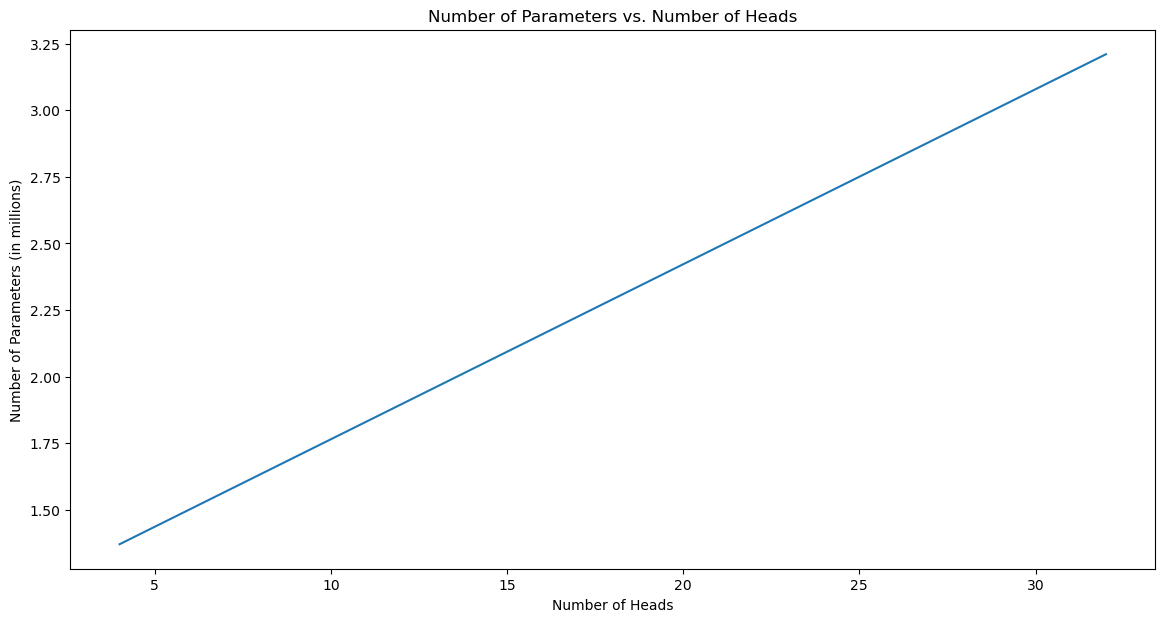

In [22]:
#   finally lets plot the number of parameters vs. number of heads (in multiples of 4, capped at 32)

num_heads_list = range(4, 33, 4)
params_by_num_heads = []

for nh in num_heads_list:
    config = Config(num_heads=nh)
    model = SastaGPT(config)
    params_by_num_heads.append(get_params(model))

plt.figure(figsize=(14, 7))
plt.plot(num_heads_list, params_by_num_heads)
plt.title('Number of Parameters vs. Number of Heads')
plt.xlabel('Number of Heads')
plt.ylabel('Number of Parameters (in millions)')
plt.show()

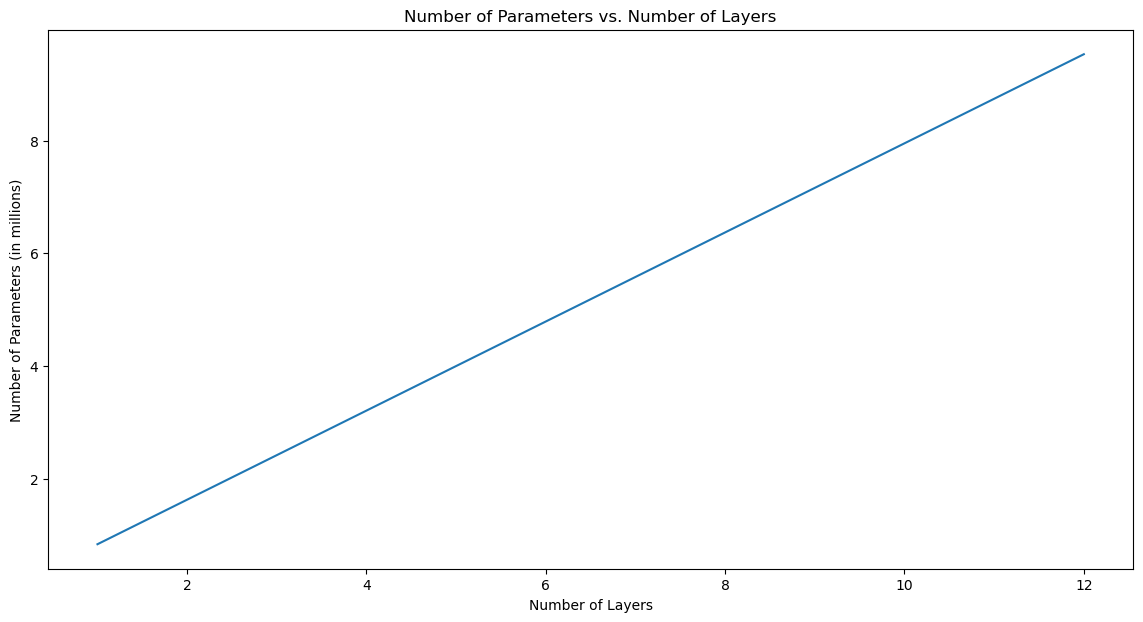

In [23]:
#    number of parameters vs. number of layers

num_layers_list = range(1, 13)  
params_by_num_layers = []

for nl in num_layers_list:
    config = Config(num_layers=nl)
    model = SastaGPT(config)
    params_by_num_layers.append(get_params(model))

plt.figure(figsize=(14, 7))
plt.plot(num_layers_list, params_by_num_layers)
plt.title('Number of Parameters vs. Number of Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Number of Parameters (in millions)')
plt.show()


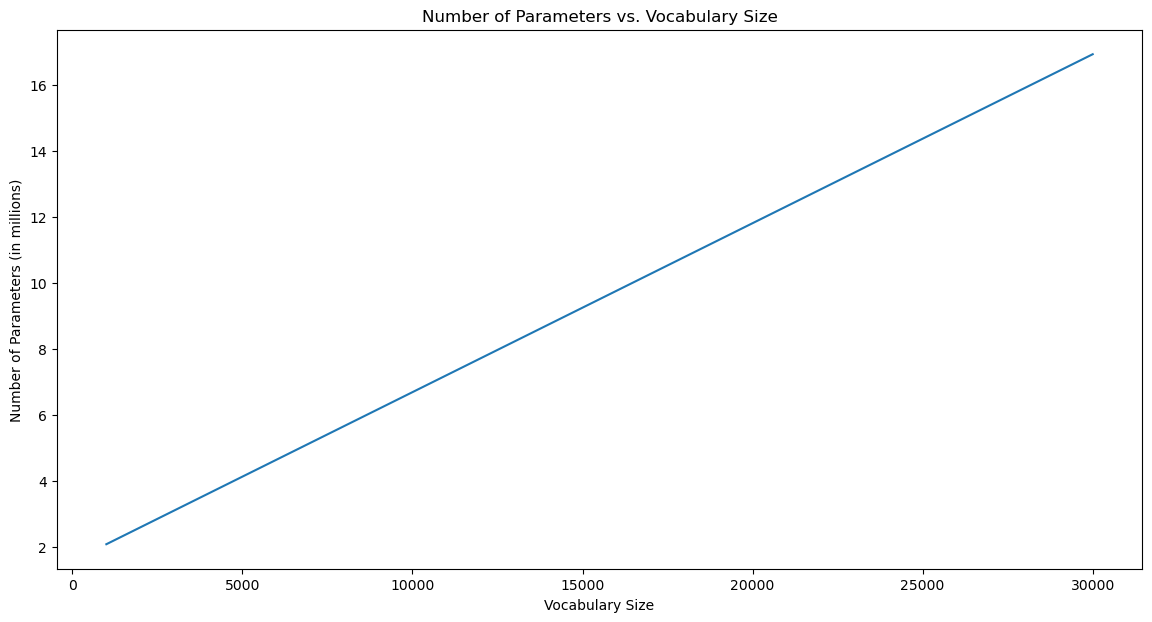

In [24]:
#   number of parameters vs. vocabulary size


vocab_sizes = range(1000, 30001, 1000)
params_by_vocab_size = []

for vs in vocab_sizes:
    config = Config(vocab_size=vs)
    model = SastaGPT(config)
    params_by_vocab_size.append(get_params(model))

plt.figure(figsize=(14, 7))
plt.plot(vocab_sizes, params_by_vocab_size)
plt.title('Number of Parameters vs. Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Number of Parameters (in millions)')
plt.show()


<span style="color: green">
    We can observe that the embedding dimension seems to have the most significant effect on the number of parameters, with a steeper and more pronounced increase. The block size appears to have the least effect, with a much gentler slope.
        
</span>